In [1]:
from typing import List, Optional
import sys
sys.path.append('C:/Users/HP/Desktop/Cours/Projet IA/neuroforest-master')
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython import display
from PIL import Image, ImageDraw, ImageFont
from scipy.spatial import cKDTree
from scipy.stats import spearmanr

from main import dataloader, to_vect, Coordinates, calculate_asrs, classify_asrs


Loading data from : C:\Users\HP\Desktop\Cours\Projet IA\data_2022\trajectories_processed
Loading data from : C:\Users\HP\Desktop\Cours\Projet IA\data_2024\trajectories_processed


In [4]:
sample = next(iter(dataloader))
session = sample["patchy"]
if session is None:
    print("No session")
    sys.exit(1)
ZOOM_FACTOR = 1.5


def transform(coords: List[Coordinates], offset: np.ndarray, factor: float) -> np.ndarray:
    return (to_vect(coords) + offset) * factor


mushrooms_coords = session.mushroom_coords
print(mushrooms_coords)
mushrooms_coords = transform(mushrooms_coords, np.array([0, 0, 0]), ZOOM_FACTOR)[:,[0, 2]]
print(mushrooms_coords)
# mushrooms_coords = mushrooms_coords[:, [0, 2]]
player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
player_coords = player_coords[:, [0, 2]]

def compute_reach_hull(coords: np.ndarray, d_reach : int = 5) -> np.ndarray:
    # Create a surface around the trajectory with the distance d_reach
    expanded_coords = []
    for coord in coords:
        for dx in [-d_reach, d_reach]:
            for dz in [-d_reach, d_reach]:
                expanded_coords.append([coord[0] + dx, coord[1] + dz])

    reach_hull = np.array(expanded_coords)
    # get the outline of the surface
    hull = cKDTree(coords)
    outline = reach_hull[hull.query(hull, k=2)[1][:]]

    return reach_hull, outline

def compute_outline(trajectory: np.ndarray, d_reach: int) -> np.ndarray:
    """
    Compute the outline of points that are at most d_reach distance from the trajectory.
    
    Parameters:
    -----------
    trajectory : np.ndarray
        Array of shape (n, 2) containing (x, y) coordinates of the trajectory points.
    d_reach : int
        Maximum distance from trajectory points.
        
    Returns:
    --------
    np.ndarray
        Array of shape (m, 2) containing the (x, y) coordinates of the outline points.
    """
    # Create a grid covering the area of interest
    min_x, min_y = np.min(trajectory, axis=0) - d_reach - 10
    max_x, max_y = np.max(trajectory, axis=0) + d_reach + 10
    
    # Create a grid with reasonable resolution (adjust step for performance/precision)
    step = max(1, d_reach // 10)  # Adjust step size based on d_reach
    step = 1
    x_grid = np.arange(min_x, max_x + step, step)
    y_grid = np.arange(min_y, max_y + step, step)
    
    # Create meshgrid for all potential points
    xx, yy = np.meshgrid(x_grid, y_grid)
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Build KD-tree for efficient distance calculation
    tree = cKDTree(trajectory)
    
    # Find points that are within d_reach of the trajectory
    distances, _ = tree.query(grid_points, k=1)
    inside_mask = distances <= d_reach
    inside_points = grid_points[inside_mask]
    
    # Convert inside points to an image-like binary grid
    grid_shape = (len(y_grid), len(x_grid))
    binary_grid = np.zeros(grid_shape, dtype=bool)
    
    # Map inside points to grid indices
    x_indices = np.round((inside_points[:, 0] - min_x) / step).astype(int)
    y_indices = np.round((inside_points[:, 1] - min_y) / step).astype(int)
    
    # Clip indices to valid range for safety
    x_indices = np.clip(x_indices, 0, grid_shape[1] - 1)
    y_indices = np.clip(y_indices, 0, grid_shape[0] - 1)
    
    binary_grid[y_indices, x_indices] = True
    
    # Use binary image processing to find the outline
    from scipy import ndimage
    eroded = ndimage.binary_erosion(binary_grid)
    outline_mask = binary_grid & ~eroded
    
    # Get coordinates of outline points
    outline_indices = np.argwhere(outline_mask)
    # Convert indices back to original coordinate system
    outline_points = np.column_stack([
        outline_indices[:, 1] * step + min_x,
        outline_indices[:, 0] * step + min_y
    ])
    
    return outline_points


max_coord_x = int(mushrooms_coords[:, 0].max())
max_coord_z = int(mushrooms_coords[:, 1].max())

[Coordinates(x=22.45751190185547, y=11.272308349609375, z=257.5749206542969), Coordinates(x=23.08479118347168, y=11.784233093261719, z=252.41258239746094), Coordinates(x=9.981305122375488, y=10.561041831970215, z=252.86033630371094), Coordinates(x=25.613401412963867, y=12.148529052734375, z=250.9549560546875), Coordinates(x=25.489364624023438, y=11.061155319213867, z=263.1846008300781), Coordinates(x=31.955692291259766, y=11.321084976196289, z=264.69744873046875), Coordinates(x=31.083467483520508, y=10.805416107177734, z=271.8065490722656), Coordinates(x=29.711368560791016, y=11.483298301696777, z=261.1425476074219), Coordinates(x=12.487532615661621, y=10.746109008789062, z=253.3604278564453), Coordinates(x=21.40829086303711, y=11.493289947509766, z=254.1429443359375), Coordinates(x=147.53245544433594, y=6.980650901794434, z=338.06634521484375), Coordinates(x=144.06793212890625, y=7.041261672973633, z=334.2296142578125), Coordinates(x=160.49533081054688, y=7.807679653167725, z=328.2052

  0%|          | 0/39 [00:00<?, ?it/s]

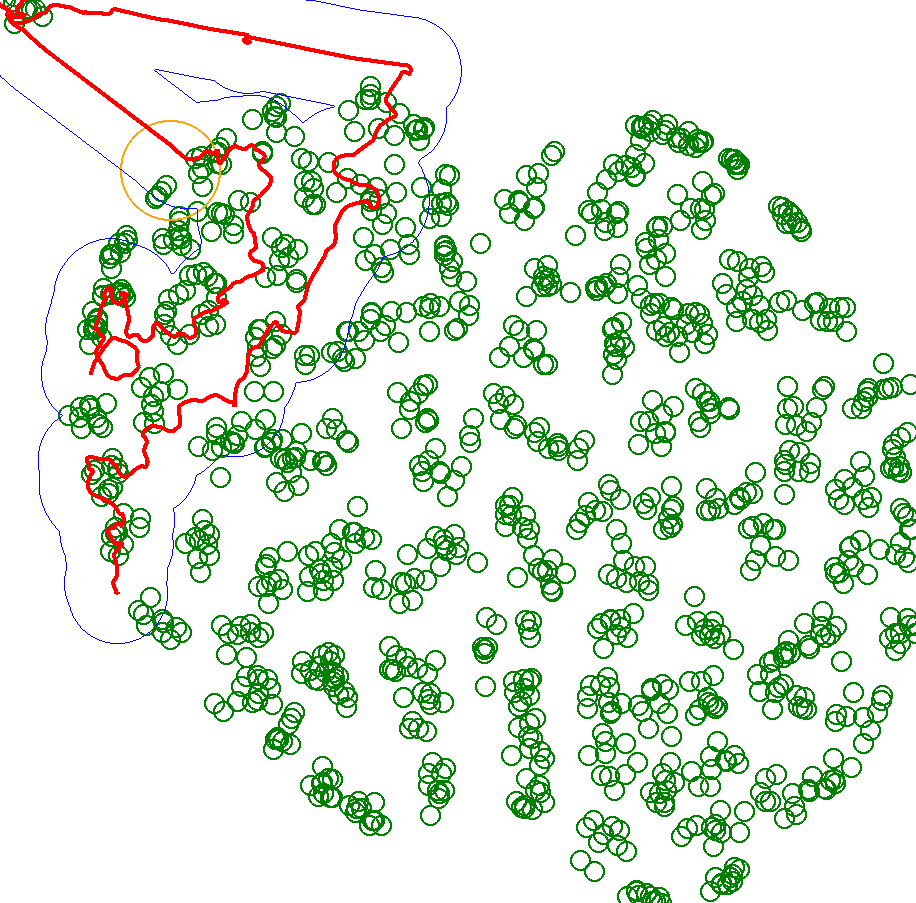

Number of reach hulls over point (170, 170) : 1


In [4]:
def count_reach_hulls_over_point(point: Coordinates, d_reach: int) -> int:
    count = 0
    with Image.new(mode="RGB", size=(max_coord_x, max_coord_z)) as im:
        draw = ImageDraw.Draw(im)
        draw.rectangle([0, 0, max_coord_x, max_coord_z], fill="white")
        for m in mushrooms_coords:
            draw.ellipse((tuple((m - 10).astype(int)), tuple((m + 10).astype(int))), outline="green", width=2)
        draw.circle(point, d_reach, outline="orange", width=2)
        for sample in tqdm(dataloader):
            session = sample["patchy"]
            if session is None:
                continue
            player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
            player_coords = player_coords[:, [0, 2]]
            traj = cKDTree(player_coords)
            # reach_hull, outline = compute_reach_hull(player_coords, d_reach)
            outline = compute_outline(player_coords, d_reach)
            if any(np.allclose(point, p, atol=d_reach) for p in player_coords):
                count += 1
                draw.line([tuple(p) for p in player_coords.astype(int)], fill=(255, 0, 0), width=4)
                draw.point([tuple(p) for p in outline.astype(int)], fill=(0, 0, 255))     
                display.display(im)
                break
    return count

# Example usage:
point = tuple([170, 170])
d_reach = 50
print(f"Number of reach hulls over point {point} : {count_reach_hulls_over_point(point, d_reach)}")


In [2]:
def count_reach_hulls_over_point_list(point_list: List[np.ndarray], d_reach: int, session_type : str) -> np.ndarray:
    counts = np.zeros(len(point_list))
    counts_gathered = np.zeros(len(point_list))
    for sample in tqdm(dataloader):
        session = sample[session_type]
        if session is None:
            continue
        coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
        coords = coords[:, [0, 2]]
        tree = cKDTree(coords)
        tab = tree.query_ball_point(point_list, d_reach)
        counts += np.array([1 if len(t)>0 else 0 for t in tab])
        gathered_mushrooms = [mush["coord"] for mush in session.gathered_mushrooms]
        gathered_mushrooms = transform(gathered_mushrooms, np.array([0, 0, 0]), ZOOM_FACTOR)[:,[0, 2]]
        counts_gathered += np.array([1 if p in gathered_mushrooms else 0 for p in point_list])
    return counts, counts_gathered

In [17]:
thresholds = [1,2,5,10,20,50]

def sum_expected_value(df_rewards: pd.DataFrame, use_gathered : Optional[str] = "") -> float:
        total_expected_value = 0
        total_exponential_value = 0
        play_last_value = 0
        count_pickups = 0
        values = np.zeros(len(thresholds))
        values_exponential = np.zeros(len(thresholds))
        for _,row in df_rewards.iterrows():
            count_pickups += 1
            total_expected_value += row[f"Expected value{use_gathered}"]
            play_last_value += row[f"Play last value{use_gathered}"]
            total_exponential_value += row[f"Expected value exponential{use_gathered}"]
            for j, threshold in enumerate(thresholds):
                if count_pickups <= threshold:
                    values[j] = total_expected_value
                    values_exponential[j] = total_exponential_value
        return total_expected_value, play_last_value, values, values_exponential



def compute_mush_rewards(mushrooms_coords: np.ndarray, d_reach: float, session_type : str) -> np.ndarray:
    if os.path.exists(f"champis_counts_session-type={session_type}_reach={d_reach}.csv"):
        df = pd.read_csv(f"champis_counts_session-type={session_type}_reach={d_reach}.csv")
    else :
        print(f"Counting champis counts for d={d_reach}; session_type={session_type} - not already calculated")
        counts, counts_gathered = count_reach_hulls_over_point_list(mushrooms_coords, d_reach=d_reach, session_type=session_type)
        df = pd.DataFrame(columns=["count", "counts_gathered", "x", "z"])
        df = df.assign(count=counts, counts_gathered=counts_gathered , x = mushrooms_coords[:, 0], z = mushrooms_coords[:, 1])
        df["Expected value"] = df["count"].apply(lambda x: 1/x if x > 1 else 1)
        df["Play last value"] = df["count"].apply(lambda x: 0 if x > 1 else 1)
        df["Expected value exponential"] = df["count"].apply(lambda x: np.exp(-x+1) if x > 1 else 1)
        df["Expected value gathered"] = df["counts_gathered"].apply(lambda x: 1/x if x > 1 else 1)
        df["Play last value gathered"] = df["counts_gathered"].apply(lambda x: 0 if x > 1 else 1)
        df["Expected value exponential gathered"] = df["counts_gathered"].apply(lambda x: np.exp(-x+1) if x > 1 else 1)
        df.sort_values(by="counts_gathered", ascending=True, inplace=True)
        df.to_csv(f"champis_counts_session-type={session_type}_reach={d_reach}.csv", index=False)
    return df



def compute_MSR(d_reach):
    dataframe = pd.DataFrame(columns=["Expected value", "Play last value"] + [f"Top-{k} values" for k in thresholds] + [f"Top-{k} exponential values" for k in thresholds] + ["ASRS"])
    for sample in tqdm(dataloader):
        for session_type in ["patchy","uniform"]:
            session = sample[session_type]
            if session is None:
                continue
            mushrooms_coords = session.mushroom_coords
            mushrooms_coords = transform(mushrooms_coords, np.array([0, 0, 0]), ZOOM_FACTOR)[:,[0, 2]]
            df = compute_mush_rewards(mushrooms_coords, d_reach, session_type)
            gathered_mushrooms = [mush["coord"] for mush in session.gathered_mushrooms]
            gathered_mushrooms = transform(gathered_mushrooms, np.array([0, 0, 0]), ZOOM_FACTOR)[:,[0, 2]]
            df_champis = df[df[["x", "z"]].apply(lambda x: x.tolist() in gathered_mushrooms.tolist(), axis=1)]
            player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
            player_coords = player_coords[:, [0, 2]]
            expected_value, play_last_value, values, values_exponential = sum_expected_value(df_champis, use_gathered=" gathered")
            asrs = classify_asrs(sample.answers)
            row = pd.DataFrame({
                                "Name":sample.subject_name, 
                                "Session type":session_type, 
                                "Expected value": [expected_value], 
                                "Play last value": [play_last_value],  
                                **{f"Top-{k} values": [values[thresholds.index(k)]] for k in thresholds}, 
                                **{f"Top-{k} exponential values" : [values_exponential[thresholds.index(k)]] for k in thresholds}, 
                                "ASRS": [asrs]
                                })
            dataframe = pd.concat([dataframe, row], ignore_index=True)

    return df,dataframe

d_reach_values = [5,15,30,50,75,100]
for d_reach in d_reach_values:
    # if not os.path.exists(f"MSR_results_{d_reach}.csv"):
        df_champis, df_results = compute_MSR(d_reach)
        df_results.to_csv(f"MSR_results_{d_reach}_gathered.csv", index=False)

  0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Temp\ipykernel_14028\1515072526.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, row], ignore_index=True)


  0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Temp\ipykernel_14028\1515072526.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, row], ignore_index=True)


  0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Temp\ipykernel_14028\1515072526.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, row], ignore_index=True)


  0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Temp\ipykernel_14028\1515072526.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, row], ignore_index=True)


  0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Temp\ipykernel_14028\1515072526.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, row], ignore_index=True)


  0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Temp\ipykernel_14028\1515072526.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, row], ignore_index=True)


In [52]:
def view_spearman(d_reach_values, thresholds, gathered=False):

        pval_matrix = np.zeros((len(d_reach_values), len(thresholds), 2, 2))
        rho_matrix = np.zeros((len(d_reach_values), len(thresholds), 2, 2))
        for i,d_reach in enumerate(d_reach_values):
                if gathered:
                        df = pd.read_csv(f"MSR_results_5_gathered.csv")
                else:
                        df = pd.read_csv(f"MSR_results_{d_reach}.csv")
                                        
                df_uniform = df[df["Session type"] == "uniform"].drop(columns=["Name", "Session type"])
                df_patchy = df[df["Session type"] == "patchy"].drop(columns=["Name", "Session type"])

                # Check and remove columns with zero variance
                uniform_std = df_uniform.std()
                patchy_std = df_patchy.std()

                # Print which columns have zero variance to understand the issue
                zero_var_uniform = uniform_std[uniform_std == 0].index.tolist()
                zero_var_patchy = patchy_std[patchy_std == 0].index.tolist()

                if zero_var_uniform:
                        print(f"D_reach {d_reach}: Zero variance in uniform data for columns: {zero_var_uniform}")
                if zero_var_patchy:
                        print(f"D_reach {d_reach}: Zero variance in patchy data for columns: {zero_var_patchy}")        

                # Remove zero-variance columns
                df_uniform = df_uniform.loc[:, uniform_std > 0]
                df_patchy = df_patchy.loc[:, patchy_std > 0]

                rho_uniform, pval_uniform = spearmanr(df_uniform, axis=0)
                rho_patchy, pval_patchy = spearmanr(df_patchy, axis=0)

                rho_uniform = rho_uniform[2:-1,-1]
                rho_patchy = rho_patchy[2:-1,-1]
                pval_uniform = pval_uniform[2:-1,-1]
                pval_patchy = pval_patchy[2:-1,-1]
                rho_uniform_uninorm = rho_uniform[:len(thresholds)]
                rho_patchy_uninorm = rho_patchy[:len(thresholds)]
                rho_uniform_expnorm = rho_uniform[len(thresholds):]
                rho_patchy_expnorm = rho_patchy[len(thresholds):]
                pval_uniform_uninorm = pval_uniform[:len(thresholds)]
                pval_patchy_uninorm = pval_patchy[:len(thresholds)]
                pval_uniform_expnorm = pval_uniform[len(thresholds):]
                pval_patchy_expnorm = pval_patchy[len(thresholds):]
                rho_matrix[i,:,0,0] = rho_uniform_uninorm
                rho_matrix[i,:,0,1] = rho_uniform_expnorm
                rho_matrix[i,:,1,0] = rho_patchy_uninorm
                rho_matrix[i,:,1,1] = rho_patchy_expnorm
                pval_matrix[i,:,0,0] = pval_uniform_uninorm
                pval_matrix[i,:,0,1] = pval_uniform_expnorm
                pval_matrix[i,:,1,0] = pval_patchy_uninorm
                pval_matrix[i,:,1,1] = pval_patchy_expnorm

                if gathered: 
                        full_mat = np.zeros((len(thresholds), 2, 2, 2))
                        full_mat[:,0,0,0] = rho_uniform_uninorm
                        full_mat[:,0,0,1] = rho_uniform_expnorm
                        full_mat[:,0,1,0] = rho_patchy_uninorm
                        full_mat[:,0,1,1] = rho_patchy_expnorm
                        full_mat[:,1,0,0] = pval_uniform_uninorm
                        full_mat[:,1,0,1] = pval_uniform_expnorm
                        full_mat[:,1,1,0] = pval_patchy_uninorm
                        full_mat[:,1,1,1] = pval_patchy_expnorm
                        
                        # Print formatted tables
                        print("\n===== Uniform Normalization =====")
                        table_headers = ["Threshold", "Uniform Corr", "Uniform p-val", "Patchy Corr", "Patchy p-val"]
                        table_data = []
                        for j, threshold in enumerate(thresholds):
                                table_data.append([
                                threshold,
                                f"{full_mat[j, 0, 0, 0]:.3f}",
                                f"{full_mat[j, 1, 0, 0]:.3f}",
                                f"{full_mat[j, 0, 1, 0]:.3f}",
                                f"{full_mat[j, 1, 1, 0]:.3f}"
                                ])
                        print(pd.DataFrame(table_data, columns=table_headers).to_string(index=False))
                        
                        print("\n===== Exponential Normalization =====")
                        table_data = []
                        for j, threshold in enumerate(thresholds):
                                table_data.append([
                                threshold,
                                f"{full_mat[j, 0, 0, 1]:.3f}",
                                f"{full_mat[j, 1, 0, 1]:.3f}",
                                f"{full_mat[j, 0, 1, 1]:.3f}",
                                f"{full_mat[j, 1, 1, 1]:.3f}"
                                ])
                        print(pd.DataFrame(table_data, columns=table_headers).to_string(index=False))
                        
                        return None
                        
                
        _, axes = plt.subplots(4, 2, figsize=(10, 7))
        sns.heatmap(rho_matrix[:,:,0,0], annot=True, xticklabels=False, yticklabels=d_reach_values, cmap="coolwarm", ax=axes[0,0], cbar = False)
        sns.heatmap(rho_matrix[:,:,0,1], annot=True, xticklabels=False, yticklabels=d_reach_values, cmap="coolwarm", ax=axes[1,0], cbar = False)
        sns.heatmap(rho_matrix[:,:,1,0], annot=True, xticklabels=False, yticklabels=d_reach_values, cmap="coolwarm", ax=axes[2,0], cbar = False)
        sns.heatmap(rho_matrix[:,:,1,1], annot=True, xticklabels=thresholds, yticklabels=d_reach_values, cmap="coolwarm", ax=axes[3,0], cbar = False)
        sns.heatmap(pval_matrix[:,:,0,0], annot=True, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=axes[0,1], cbar = False)
        sns.heatmap(pval_matrix[:,:,0,1], annot=True, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=axes[1,1], cbar = False)
        sns.heatmap(pval_matrix[:,:,1,0], annot=True, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=axes[2,1], cbar = False)
        sns.heatmap(pval_matrix[:,:,1,1], annot=True, xticklabels=thresholds, yticklabels=False, cmap="coolwarm", ax=axes[3,1], cbar = False)
        axes[0,0].set_title("Correlation for uniform session with uniform values")
        axes[1,0].set_title("Correlation for uniform session with exponential values")
        axes[2,0].set_title("Correlation for patchy session with uniform values")
        axes[3,0].set_title("Correlation for patchy session with exponential values")
        axes[0,1].set_title("P-value for uniform session with uniform values")
        axes[1,1].set_title("P-value for uniform session with exponential values")
        axes[2,1].set_title("P-value for patchy session with uniform values")
        axes[3,1].set_title("P-value for patchy session with exponential values")
        plt.tight_layout()
        plt.show()

In [53]:
view_spearman(d_reach_values, thresholds, gathered=True)


===== Uniform Normalization =====
 Threshold Uniform Corr Uniform p-val Patchy Corr Patchy p-val
         1        0.159         0.334       0.206        0.214
         2        0.303         0.060       0.086        0.608
         5        0.256         0.115      -0.020        0.907
        10        0.264         0.104      -0.007        0.968
        20        0.319         0.048       0.006        0.973
        50        0.330         0.040       0.047        0.777

===== Exponential Normalization =====
 Threshold Uniform Corr Uniform p-val Patchy Corr Patchy p-val
         1        0.159         0.334       0.206        0.214
         2        0.303         0.060       0.086        0.608
         5        0.255         0.117      -0.020        0.904
        10        0.266         0.102      -0.010        0.953
        20        0.294         0.069      -0.013        0.937
        50        0.274         0.092      -0.015        0.927
